---

# Clasificación de imágenes HAM10000 mediante CNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dropout, BatchNormalization
from keras.regularizers import l2,l1,L1L2
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.metrics import Precision, SensitivityAtSpecificity, Accuracy
from keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

import tensorflow as tf
import random

# Lectura de los datos

In [2]:
path = "/kaggle/input/lmn-ham10000/dataverse_files"

dir_list = os.listdir(path)
print("Files and directories in '", path, "' :")
# prints all files
print(dir_list)

Files and directories in ' /kaggle/input/lmn-ham10000/dataverse_files ' :
['HAM10000_segmentations_lesion_tschandl', 'HAM10000_images', 'train_img_mask_label_id.tfrecord', 'HAM10000_metadata.csv']


In [3]:
df = pd.read_csv(path+'/HAM10000_metadata.csv')
print('labels: ',df['dx'].unique())

int_lables = df['dx'].astype('category').cat.codes

print('labels codificadas: ', int_lables.unique())

df['int_labels'] = int_lables

display(df)

labels = np.array(np.int32(df['int_labels'].values))

labels:  ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
labels codificadas:  [2 5 3 4 6 1 0]


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,int_labels
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,0


In [4]:
unique_classes, counts = np.unique(labels, return_counts=True)
# Crear un diccionario con el número de imágenes necesarias para cada clase
cantidad_por_clase = {cls: count for cls, count in zip(unique_classes, counts)}

print('Cantidad de imágenes por clase: ', cantidad_por_clase)

Cantidad de imágenes por clase:  {0: 327, 1: 514, 2: 1099, 3: 115, 4: 1113, 5: 6705, 6: 142}


Claramente, hay un desbalance en los datos que deberá ser tenido en cuenta para el entrenamiento.

In [5]:
# Ruta a las imágenes y las etiquetas
image_folder = path +'/HAM10000_images'

# Obtener rutas de las imágenes
image_paths = tf.io.gfile.glob(f"{image_folder}/*")

df['paths'] = image_paths

display(df)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,int_labels,paths
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2,/kaggle/input/lmn-ham10000/dataverse_files/HAM...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2,/kaggle/input/lmn-ham10000/dataverse_files/HAM...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2,/kaggle/input/lmn-ham10000/dataverse_files/HAM...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2,/kaggle/input/lmn-ham10000/dataverse_files/HAM...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2,/kaggle/input/lmn-ham10000/dataverse_files/HAM...
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,0,/kaggle/input/lmn-ham10000/dataverse_files/HAM...
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,0,/kaggle/input/lmn-ham10000/dataverse_files/HAM...
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,0,/kaggle/input/lmn-ham10000/dataverse_files/HAM...
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,0,/kaggle/input/lmn-ham10000/dataverse_files/HAM...


# Balanceo de clases

Existen distintas estrategias para compensar el desbalance de datos. Una de ellas consiste en la generación de imágenes tal que cada clase posea la misma cantidad de imágenes. Se intentó llevar a cabo este técnica pero los tiempos de cómputo hacían imposible analizar adecuadamente su efecto. Por esta razón, se decidió probar con tres técnicas más: compensación de pesos, inicialización de pesos y recorte del dataset. De estas últimas tres técnicas, solamente vamos a desarrollar la última, puesto que las otras generaban redes con un nivel de accuracy muy bajo o redes absolutamente sesgadas hacia la clase con mayor cantidad de datos.


Los resultados de aplicar un recrote de datos no son lo más adecuado, debido a la reducida cantidad de imágenes restantes en el dataset. Aún así, perimitió observar el efecto de distintas arquitecturas, junto a su regularización, efectos que con las otras técnicas no ocurría.

El recorte de datos se hizo de tal manera, tal que las clases tuvieran como máximo la mediana de las cantidad de imágenes originales en cada clase. La mediana es de 514, por lo tanto, ese será el máximo de imágenes para algunas clases.

In [6]:
# Paths de las imágenes para cada clase
lista_paths_por_clase = [list(df.loc[df['int_labels'] == cls, 'paths']) for cls in unique_classes]

# Selección aleatoria de cantidad máxima de imágenes dentro de cada clase
lista_paths_por_clase_cortadas = []
for lista in lista_paths_por_clase:

    indexes = list(range(len(lista)))
    random.shuffle(indexes)
    
    if len(lista) < np.median(counts):
        lista_paths_por_clase_cortadas.append(lista)
    else:
        lista_cut = [lista[i] for i in indexes[:int(np.median(counts))]]
        lista_paths_por_clase_cortadas.append(lista_cut)

lista_labels_por_clase = []
for cls, lista in zip(unique_classes,lista_paths_por_clase_cortadas):
    lista_label_cut = [cls for i in range(len(lista))]
    lista_labels_por_clase.append(lista_label_cut)

# Merge de listas
union_paths = []
for lista in lista_paths_por_clase_cortadas:
    union_paths += list(lista)

union_labels = []
for lista in lista_labels_por_clase:
    union_labels += list(lista)

data = {'paths': union_paths,
        'labels': union_labels}
df_selected = pd.DataFrame(data)

display(df_selected)
print(df_selected['paths'][0])

,paths,labels
0,/kaggle/input/lmn-ham10000/dataverse_files/HAM...,0
1,/kaggle/input/lmn-ham10000/dataverse_files/HAM...,0
2,/kaggle/input/lmn-ham10000/dataverse_files/HAM...,0
3,/kaggle/input/lmn-ham10000/dataverse_files/HAM...,0
4,/kaggle/input/lmn-ham10000/dataverse_files/HAM...,0
...,...,...
2635,/kaggle/input/lmn-ham10000/dataverse_files/HAM...,6
2636,/kaggle/input/lmn-ham10000/dataverse_files/HAM...,6
2637,/kaggle/input/lmn-ham10000/dataverse_files/HAM...,6
2638,/kaggle/input/lmn-ham10000/dataverse_files/HAM...,6


/kaggle/input/lmn-ham10000/dataverse_files/HAM10000_images/ISIC_0029472.jpg


# Creación de los datasets

In [10]:
paths_train, paths_val, labels_train, labels_val = train_test_split(union_paths, union_labels, test_size=0.20)

print('TRAIN\n')

unique_classes, counts = np.unique(labels_train, return_counts=True)
cantidad_por_clase_train = {cls: count for cls, count in zip(unique_classes, counts)}
porcentaje_por_clase_train = {cls: 100*count/np.sum(counts)  for cls, count in zip(unique_classes, counts)}
print('Cantidad de imágenes por clase: ', cantidad_por_clase_train)
print('Total: ', np.sum(counts))
print('Proporción de imágenes por clase: ', porcentaje_por_clase_train)

print('\nVAL\n')

unique_classes, counts = np.unique(labels_val, return_counts=True)
cantidad_por_clase_val = {cls: count for cls, count in zip(unique_classes, counts)}
porcentaje_por_clase_val = {cls: 100*count/np.sum(counts) for cls, count in zip(unique_classes, counts)}
print('Cantidad de imágenes por clase: ', cantidad_por_clase_val)
print('Total: ', np.sum(counts))
print('Proporción de imágenes por clase: ', porcentaje_por_clase_val)

labels_train = to_categorical(labels_train, num_classes=7)
labels_val = to_categorical(labels_val, num_classes=7)

TRAIN

Cantidad de imágenes por clase:  {0: 251, 1: 417, 2: 415, 3: 90, 4: 410, 5: 415, 6: 114}
Total:  2112
Proporción de imágenes por clase:  {0: 11.884469696969697, 1: 19.744318181818183, 2: 19.64962121212121, 3: 4.261363636363637, 4: 19.41287878787879, 5: 19.64962121212121, 6: 5.3977272727272725}

VAL

Cantidad de imágenes por clase:  {0: 76, 1: 97, 2: 99, 3: 25, 4: 104, 5: 99, 6: 28}
Total:  528
Proporción de imágenes por clase:  {0: 14.393939393939394, 1: 18.37121212121212, 2: 18.75, 3: 4.734848484848484, 4: 19.696969696969695, 5: 18.75, 6: 5.303030303030303}


Las clases ahora sí se encuentran más balanceadas. Se optó por no balancearlas al 100% debido a la extrema reducción de datos.

Las imágenes se normalizan y se utiliza un resize para obtener imágenes de (100,133), para mantener la relación de aspecto original ( (450,600) ).

In [11]:
X_train = np.array([cv2.resize(cv2.imread(path), (133, 100))/255.0 for path in paths_train])
X_val = np.array([cv2.resize(cv2.imread(path), (133, 100))/255.0 for path in paths_val])

# Definición de métricas

Las métricas a utilizas consisten en:

- Accuracy
- Sensitivity
- Specificity

In [12]:
from tensorflow.keras import backend as K

# Sensitivity (Recall)
def sensitivity(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred = K.one_hot(y_pred, num_classes=K.int_shape(y_true)[-1])
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    return K.mean(true_positives / (possible_positives + K.epsilon()))

# Specificity
def specificity(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred = K.one_hot(y_pred, num_classes=K.int_shape(y_true)[-1])
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)), axis=0)
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)), axis=0)
    return K.mean(true_negatives / (possible_negatives + K.epsilon()))

El siguiente método tiene como objetivo calcular las compensaciones de los pesos debido al leve desbalanceo de datos. Esta compensación es utilizada a la hora de entrenar la red.

In [13]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(union_labels),
    y=union_labels)

class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: 1.1533420707732633, 1: 0.7337409672040022, 2: 0.7337409672040022, 3: 3.279503105590062, 4: 0.7337409672040022, 5: 0.7337409672040022, 6: 2.6559356136820926}


# Definición del modelo de CNN sin regularización y entrenamiento

In [26]:
lr = 0.001

# Input
input = Input(shape=(100, 133, 3))

# Body - Convolution
x = Conv2D(16, (3, 3), activation='relu')(input)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)

# Body - Dense
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

# Output
output = Dense(7, activation='softmax')(x)

model_cnn = Model(input, output)

model_cnn.summary()

model_cnn.compile(
    optimizer               = Adam(learning_rate=lr),
    loss                    = 'categorical_crossentropy',
    metrics                 = ['Accuracy',sensitivity,specificity]
)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 100, 133, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 98, 131, 16)    │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 49, 65, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 47, 63, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 23, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 21, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 10, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │     4,588,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,776,743 (18.22 MB)

 Trainable params: 4,776,743 (18.22 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
es = EarlyStopping(
    monitor = "val_Accuracy",
    patience = 20,
    verbose = 1,
    restore_best_weights = True,
)

history_cnn = model_cnn.fit(
    x = X_train,
    y = labels_train,
    validation_data = (X_val,labels_val),
    batch_size = 16,
    epochs = 50,
    callbacks = [es],
    class_weight = class_weights
)

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - Accuracy: 0.1797 - loss: 1.9636 - sensitivity: 0.1329 - specificity: 0.8575 - val_Accuracy: 0.1970 - val_loss: 1.9462 - val_sensitivity: 0.1385 - val_specificity: 0.8571
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Accuracy: 0.2074 - loss: 1.9391 - sensitivity: 0.1369 - specificity: 0.8570 - val_Accuracy: 0.0473 - val_loss: 1.9488 - val_sensitivity: 0.0823 - val_specificity: 0.8571
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Accuracy: 0.1108 - loss: 1.9090 - sensitivity: 0.1085 - specificity: 0.8572 - val_Accuracy: 0.0473 - val_loss: 1.9481 - val_sensitivity: 0.0823 - val_specificity: 0.8571
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Accuracy: 0.0553 - loss: 1.9617 - sensitivity: 0.0778 - specificity: 0.8572 - val_Accuracy: 0.1837 - val_loss: 1.9453 - val_sensitivity: 0.1385 - val_specificity: 0.8571
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Accuracy: 0.1677 - loss: 1.9796 - sensitivity: 0

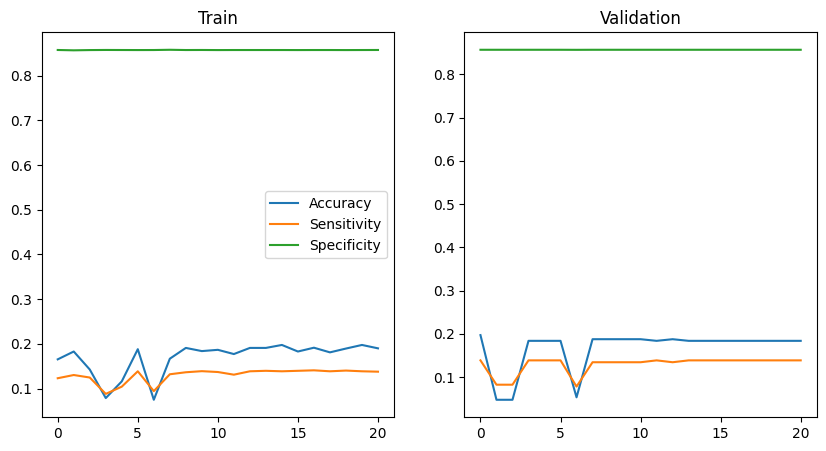

In [28]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
ax.plot(history_cnn.history['Accuracy'],label='Accuracy')
ax.plot(history_cnn.history['sensitivity'],label='Sensitivity')
ax.plot(history_cnn.history['specificity'],label='Specificity')
ax.set_title('Train')
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.plot(history_cnn.history['val_Accuracy'],label='Accuracy')
ax.plot(history_cnn.history['val_sensitivity'],label='Sensitivity')
ax.plot(history_cnn.history['val_specificity'],label='Specificity')
ax.set_title('Validation')

plt.show()

Tanto el training como el validation entregaron resultados similares, con un Accuracy de caso el 20% en ambos casos. Con respecto a la especificidad, tanto el train como el validation dieron exactamente igual y de un valor muy alto, mientras que la sensibilidad fue ligeramente mayor en la validación.

La red posee claras limitaciones para distinguir las imágenes de las distintas clases de patologías, donde el 20% de las veces puede clasificarlas correctamente. Existen distinas hipótesis que pueden explicar la dificultad para clasificar las imágenes correctamente.

La primera de ellas consiste en la naturaleza propia del dataset por encontrarse desbalanceado. Otra de las razones puede deberse al tipo de imágenes propiamente dichas, las cuales consisten en fotografías de lesiones en la piel cuya similitud es muy alta. Acoplado a esta última hipótesis, se encuentra el hecho de que la red convolucional es pequeña, de baja capacidad de cómputo. Por último, existe la posibilidad de que la clasificación de las imágenes entregue mejores resultados llevando a cabo un procesamiento más fino de las imágenes iniciales, como por ejemplo, la utilización de una sola de las capas RGB más distintivas de las imágenes, como la G o la B, debido a los tonos rojizos de las imágenes. Suponemos que el contraste en estas capas puedan revelar detalles que las imágenes a RGB no ofrezcan y/o la red no es capaz de reconocer debido a su corta extensión.

# CNN con regularización y entrenamiento

Se agregan etapas de data augmentation y un pequeño dropout a la red convolucional anterior.

In [32]:
lr = 0.001

# Input
input = Input(shape=(100, 133, 3))

data_augmentation = RandomFlip("horizontal", name='random_flip')(input)
data_augmentation = RandomRotation(0.1, name='random_rotation')(data_augmentation)
data_augmentation = RandomZoom(0.1, name='random_zoom')(data_augmentation)
data_augmentation = RandomContrast(0.2, name='random_contrast')(data_augmentation)
data_augmentation = RandomTranslation(height_factor=0.1, width_factor=0.1)(data_augmentation)

# Body - Convolution
x = Conv2D(16, (3, 3), activation='relu')(input)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)

# Body - Dense
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.01)(x)
x = Dense(128, activation='relu')(x)

# Output
output = Dense(7, activation='softmax')(x)

model_cnn_reg = Model(input, output)

model_cnn_reg.summary()

model_cnn_reg.compile(
    optimizer               = Adam(learning_rate=lr),
    loss                    = 'categorical_crossentropy',
    metrics                 = ['Accuracy',sensitivity,specificity]
)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 100, 133, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 98, 131, 16)    │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 49, 65, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 47, 63, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 23, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 21, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 10, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 8960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │     4,588,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,776,743 (18.22 MB)

 Trainable params: 4,776,743 (18.22 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
es = EarlyStopping(
    monitor = "val_Accuracy",
    patience = 20,
    verbose = 1,
    restore_best_weights = True,
)

history_cnn_reg = model_cnn_reg.fit(
    x = X_train,
    y = labels_train,
    validation_data = (X_val,labels_val),
    batch_size = 16,
    epochs = 50,
    callbacks = [es],
    class_weight = class_weights
)

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - Accuracy: 0.1481 - loss: 1.9268 - sensitivity: 0.1243 - specificity: 0.8574 - val_Accuracy: 0.1875 - val_loss: 1.9457 - val_sensitivity: 0.1385 - val_specificity: 0.8571
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Accuracy: 0.0979 - loss: 1.9406 - sensitivity: 0.0954 - specificity: 0.8572 - val_Accuracy: 0.1875 - val_loss: 1.9445 - val_sensitivity: 0.1385 - val_specificity: 0.8571
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Accuracy: 0.1875 - loss: 1.9907 - sensitivity: 0.1433 - specificity: 0.8572 - val_Accuracy: 0.1875 - val_loss: 1.9438 - val_sensitivity: 0.1385 - val_specificity: 0.8571
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Accuracy: 0.1863 - loss: 1.9322 - sensitivity: 0.1340 - specificity: 0.8572 - val_Accuracy: 0.1875 - val_loss: 1.9441 - val_sensitivity: 0.1385 - val_specificity: 0.8571
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Accuracy: 0.1297 - loss: 1.9769 - sensitivity: 0

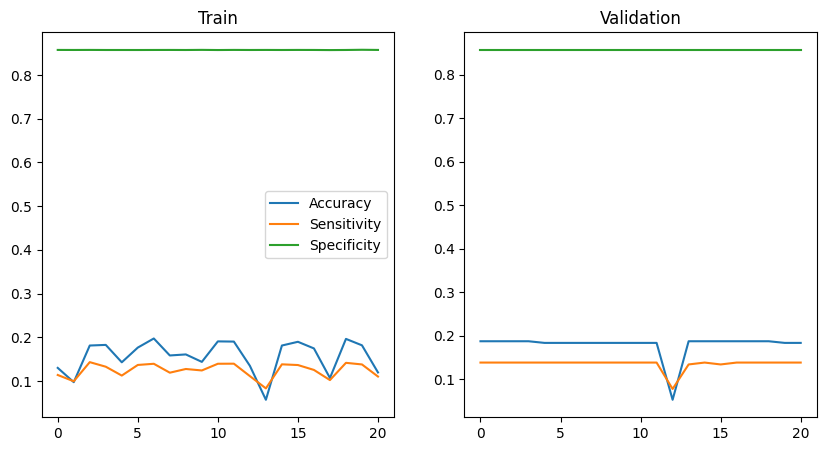

In [34]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
ax.plot(history_cnn_reg.history['Accuracy'],label='Accuracy')
ax.plot(history_cnn_reg.history['sensitivity'],label='Sensitivity')
ax.plot(history_cnn_reg.history['specificity'],label='Specificity')
ax.set_title('Train')
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.plot(history_cnn_reg.history['val_Accuracy'],label='Accuracy')
ax.plot(history_cnn_reg.history['val_sensitivity'],label='Sensitivity')
ax.plot(history_cnn_reg.history['val_specificity'],label='Specificity')
ax.set_title('Validation')

plt.show()

Los resultados son muy similares al caso anterior, solo que el trainining registró un variación más fuerte.

A pesar de agregar elementos de regularización, los mismos no lograron mejorar los resultados en la etapa de validación. Las hipótesis de porqué se obtienen estos resultados sigue siendo las mismas que en el caso anterior. Consideramos sumamente importante un procesamiento previo de las imágenes para destacar características significativas de las lesiones, puesto que la red no puede disinguirlas por sí misma.

## Conclusiones del análisis de los resultados de las dos redes anteriores

Ambas redes presentan dificultades para comprender las características particulares de las 7 clases de patologías. En ambas redes, la sensibilidad o la capacidad de detectar verdaderos positivos es menor al 20%, pero la especificidad o la capacidad de distinguir verdaderos negativos es mayor al 80%.

# VGG - Entrenamiento con pesos del modelo congelado

In [38]:
# Cargar VGG16 preentrenada en ImageNet sin la capa superior
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(100, 133, 3))
base_model_vgg.trainable = False  # Congelar capas de VGG16


In [39]:
lr = 0.0001

# Construir el modelo
model_vgg = Sequential([
    base_model_vgg,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(256, activation='relu'),
    Dense(7, activation='softmax')
])

model_vgg.summary()

# Compilar el modelo
model_vgg.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['Accuracy',sensitivity,specificity])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [40]:
es = EarlyStopping(
    monitor = "val_Accuracy",
    patience = 20,
    verbose = 1,
    restore_best_weights = True,
)

history_vgg = model_vgg.fit(
    x = X_train,
    y = labels_train,
    validation_data = (X_val,labels_val),
    batch_size = 32,
    epochs = 20,
    callbacks = [es]
)

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - Accuracy: 0.1820 - loss: 1.9122 - sensitivity: 0.1472 - specificity: 0.8565 - val_Accuracy: 0.1799 - val_loss: 1.8859 - val_sensitivity: 0.1398 - val_specificity: 0.8564
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - Accuracy: 0.2274 - loss: 1.8199 - sensitivity: 0.1718 - specificity: 0.8646 - val_Accuracy: 0.1894 - val_loss: 1.8618 - val_sensitivity: 0.1415 - val_specificity: 0.8569
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - Accuracy: 0.2307 - loss: 1.7877 - sensitivity: 0.1745 - specificity: 0.8647 - val_Accuracy: 0.1894 - val_loss: 1.8694 - val_sensitivity: 0.1435 - val_specificity: 0.8576
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - Accuracy: 0.2893 - loss: 1.7460 - sensitivity: 0.2051 - specificity: 0.8710 - val_Accuracy: 0.1913 - val_loss: 1.8800 - val_sensitivity: 0.1513 - val_specificity: 0.8573
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - Accuracy: 0.3122 - loss: 1.7205 - sensitivity: 0.2382

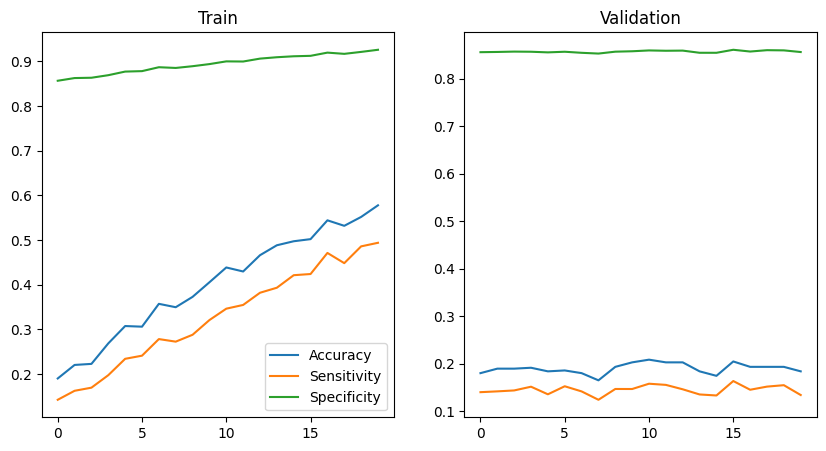

In [41]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
ax.plot(history_vgg.history['Accuracy'],label='Accuracy')
ax.plot(history_vgg.history['sensitivity'],label='Sensitivity')
ax.plot(history_vgg.history['specificity'],label='Specificity')
ax.set_title('Train')
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.plot(history_vgg.history['val_Accuracy'],label='Accuracy')
ax.plot(history_vgg.history['val_sensitivity'],label='Sensitivity')
ax.plot(history_vgg.history['val_specificity'],label='Specificity')
ax.set_title('Validation')

plt.show()

En el training, la red pudo aprender a distinguir las clases en mayor medida, pero esto fue solamente con el set de train, puesto que en la validación el nivel de Accuracy descendió. Esto es unclaro síntoma de overfitting que debería ser compensado de alguna manera.

Debido a la acrquitectura de mayor extensión de VGG, la red puede aprender en mayor medidas las características intrínsecas de las imágenes. La intención a futuro es poder replicar este bien comportamiento tanto en la etapa de training como en validation.

# VGG - Entrenamiento con algunos pesos del modelo descongelados

In [42]:
# Desbloquear algunas capas para Fine-Tuning
for layer in base_model_vgg.layers[-4:]:  # Desbloquear las últimas 4 capas
    layer.trainable = True

model_vgg = Sequential([
    base_model_vgg,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(256, activation='relu'),
    Dense(7, activation='softmax')
])

# Compilar el modelo nuevamente (necesario al cambiar capas entrenables)
model_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['Accuracy',sensitivity,specificity])

history_vgg_finetune = model_vgg.fit(
    x = X_train,
    y = labels_train,
    validation_data = (X_val,labels_val),
    batch_size = 32,
    epochs = 20,
    callbacks = [es],
)

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - Accuracy: 0.1993 - loss: 1.8696 - sensitivity: 0.1459 - specificity: 0.8570 - val_Accuracy: 0.1610 - val_loss: 1.8462 - val_sensitivity: 0.1194 - val_specificity: 0.8527
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - Accuracy: 0.1934 - loss: 1.8389 - sensitivity: 0.1472 - specificity: 0.8585 - val_Accuracy: 0.1780 - val_loss: 1.8460 - val_sensitivity: 0.1253 - val_specificity: 0.8542
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - Accuracy: 0.2098 - loss: 1.8107 - sensitivity: 0.1498 - specificity: 0.8588 - val_Accuracy: 0.1894 - val_loss: 1.8529 - val_sensitivity: 0.1444 - val_specificity: 0.8573
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - Accuracy: 0.2195 - loss: 1.8128 - sensitivity: 0.1539 - specificity: 0.8600 - val_Accuracy: 0.1856 - val_loss: 1.8592 - val_sensitivity: 0.1378 - val_specificity: 0.8570
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - Accuracy: 0.2555 - loss: 1.7738 - sensitivity: 0.1805 -

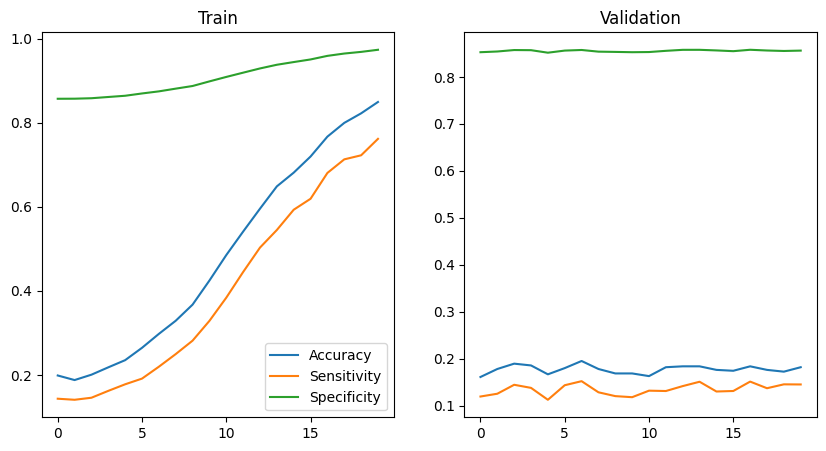

In [43]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
ax.plot(history_vgg_finetune.history['Accuracy'],label='Accuracy')
ax.plot(history_vgg_finetune.history['sensitivity'],label='Sensitivity')
ax.plot(history_vgg_finetune.history['specificity'],label='Specificity')
ax.set_title('Train')
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.plot(history_vgg_finetune.history['val_Accuracy'],label='Accuracy')
ax.plot(history_vgg_finetune.history['val_sensitivity'],label='Sensitivity')
ax.plot(history_vgg_finetune.history['val_specificity'],label='Specificity')
ax.set_title('Validation')

plt.show()

Comparado con la red anterior, al desbloquear las últimas capas del modelo VGG, la red pudo aprender aún más las características de las imágenes en el training. Sigue existiendo un overfitting que debe ser compensado, pero es una buena noticia que la red sea capas de aprender con un accuracy de 80% en pocos epochs y tiempo de entrenamiento. 

## Conclusiones del análsis de resultados del entreanimento de redes utilizado VGG

En comparación con las redes CNN entrenadas anteriormente, la performance de las redes VGG es superior. Aún así, es importante destacar el claro overfitting de las mismas, por lo que este es un punto a considerar a la hora de utilizas los modelos con VGG.

# Conclusiones del análisis de resultados de todas las redes entrenadas

Todas las redes han podido ser entrenadas en términos de pocos minutos. Si bien las redes con el modelo VGG resultaron más precisos en la clasificación múltiple, ninguna red pudo superar el 20% de la precisión en el set de validación, un síntoma de overfitting o falta de datos.

Consideramos que la disminución de datos no es la mejor de las técnicas para balancear las clases, pero logra mostrar resultados que no son posibles de observar con el dataset completo y sesgado a la clase 5.

Por último, las redes son mejores en especificad que en sensibilidad.